# The Movie Buffs 

### Analyzing box office movie data to spot trends related to movie success.

#### Collaborators: Barry Haygood, Cathy Egboh, Maya Saeidi, and Michelle Brucato

In [4]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import os
import locale  # to format currency as USD
from pandas.io.json import json_normalize
import datetime
import graphs 

locale.setlocale(locale.LC_ALL, "")

from api_keys import api_key

# Output File (CSV)
output_data_file = "tmbddata_dev.csv"
movie_revenue_data = "tmbd_dev_movie_revenue.csv"
final_data = "tmbd_data_final.csv"

# Perform API calls to retrieve all necessary data
### Retrieve movie titles, release date, critic vote score, and movie revenue (USD). 

In [ ]:
# Generate Movies Database from TMBD API by looping though all pages
all_results = []
url = "https://api.themoviedb.org/3/discover/movie/"
page = 1
while True:
    r = requests.get(
        url + "?api_key=" + api_key + "&language=en-US" + "&page=" + str(page)
    )
    movie_data = r.json()
    if r.status_code == 200:
        all_results.append(movie_data)
        page += 1
    else:
        break

In [ ]:
# Create dataframe to store movie data movie_df
movie_df = pd.io.json.json_normalize(all_results, record_path="results")

# Create CSV file of raw data from TMBD API and store in Results Directory
script_dir = os.path.dirname("")
results_dir = os.path.join(script_dir, "Results/")
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

# Create directory to store results    
movie_df.to_csv(results_dir + output_data_file)

movie_ids = movie_df["id"].tolist()

In [ ]:
def get_movie_revenue(id, api_key):

    url = "https://api.themoviedb.org/3/movie/"

    r = requests.get(
        url
        + str(id)
        + "?api_key="
        + api_key
        + "&language=en-US"
        + "&sort_by=revenue.desc"
    )

    if r.status_code == 200:
        return r.json()
    else:
        return None

movie_revenue = []

for id in movie_ids:
    result = get_movie_revenue(id, api_key)
    if result:
        movie_revenue.append(result)

# Perform data munging to narrow scope to necessary fields   
### Adjust for inflation for movie budget and revenue

In [ ]:
movie_revenue_df = pd.io.json.json_normalize(movie_revenue)
movie_revenue_df.to_csv(results_dir + movie_revenue_data)

# Import FRED Consumer Price Index for Urban Consumers 
path = os.path.join("Data", "CPIAUCNS.csv")
inflation_df = pd.read_csv(path)

In [ ]:
indexNames = movie_revenue_df[movie_revenue_df["revenue"] <= 0].index
movie_revenue_df.drop(indexNames, inplace=True)

indexNames = movie_revenue_df[movie_revenue_df["budget"] <= 0].index
movie_revenue_df.drop(indexNames, inplace=True)

movie_revenue_df["profit"] = movie_revenue_df["revenue"] - movie_revenue_df["budget"]

In [ ]:
# Convert release date to month/year and create new column called release month
movie_revenue_df["month"] = pd.to_datetime(
    movie_revenue_df["release_date"]
).dt.to_period("M")

In [ ]:
columns_drop = [
    "adult",
    "backdrop_path",
    "belongs_to_collection",
    "poster_path",
    "genres",
    "tagline",
    "video",
    "belongs_to_collection.id",
    "belongs_to_collection.name",
    "belongs_to_collection.poster_path",
    "belongs_to_collection.backdrop_path",
]
movie_revenue_df.drop(columns_drop, axis=1, inplace=True)

In [ ]:
# create index multiplier
inflation_df["CPI_multiplier"] = (
    inflation_df["CPIAUCNS"].iloc[-1] / inflation_df["CPIAUCNS"]
)

inflation_df["month"] = pd.to_datetime(inflation_df["DATE"]).dt.to_period("M")

# Merge CPI dataframe to movie_revenue_df by matching month
final_df = pd.merge(movie_revenue_df, inflation_df, how="left", on="month")

# Create CPI adjusted profit revenue and budget columns
final_df["CPIAdjProfit"] = final_df["profit"] * final_df["CPI_multiplier"]
final_df["CPIAdjRevenue"] = final_df["revenue"] * final_df["CPI_multiplier"]
final_df["CPIAdjBudget"] = final_df["budget"] * final_df["CPI_multiplier"]

# Remove new releases from dataset (released after 11/1/19)
indexNames = final_df[final_df["month"] > datetime.date(2019, 11, 1)].index
final_df.drop(indexNames, inplace=True)

final_df.to_csv(results_dir + final_data)

# Import Oscars data and perform data munging
### Focus on movies released after 1980
### Focus on movies nominated for Best Picture

In [ ]:
# Create new dataframe with pre 1980 Release Data removed
tmbd_data_post_1980_df = final_df
tmbd_data_post_1980_df = tmbd_data_post_1980_df
indexNames = tmbd_data_post_1980_df[tmbd_data_post_1980_df["month"] < datetime.date(1980, 1, 1)].index
tmbd_data_post_1980_df.drop(indexNames, inplace=True)

tmbd_data_post_1980_df.to_csv(results_dir + "TMBD_data_post_1980.csv")

#Load oscar data to dataframe
path = os.path.join("Data", "data_csv.csv")
oscars_df = pd.read_csv(path)

#Merge Oscar data with post 1980 movie data 
bestpic_df = pd.merge(tmbd_data_post_1980_df, oscars_df, how = "left", left_on ="title", right_on='entity')

#Create conditions to annote Best_Picture Winner,Nominee, No
cond1 = bestpic_df.category.str.contains('BEST PICTURE')
cond2 = bestpic_df['winner'] == True

#Denote Best Picture Restult
bestpic_df['category'] = bestpic_df['category'].fillna('missing')
bestpic_df['Best_Picture'] = np.where(np.logical_and(cond1 == True, cond2), "Winner", "Nominee")
bestpic_df.loc[bestpic_df['category'].str.contains("BEST PICTURE")==0,'Best_Picture'] = "No"


bestpic_df.to_csv(results_dir + "TMBD_Data_best_picture.csv")

# Visualize Movie Data

<h2><center>Total sum of movie releases by year, from 1906 to 2019.</center></h2>

* Throughout the years, total amount of movie releases has continued to increase

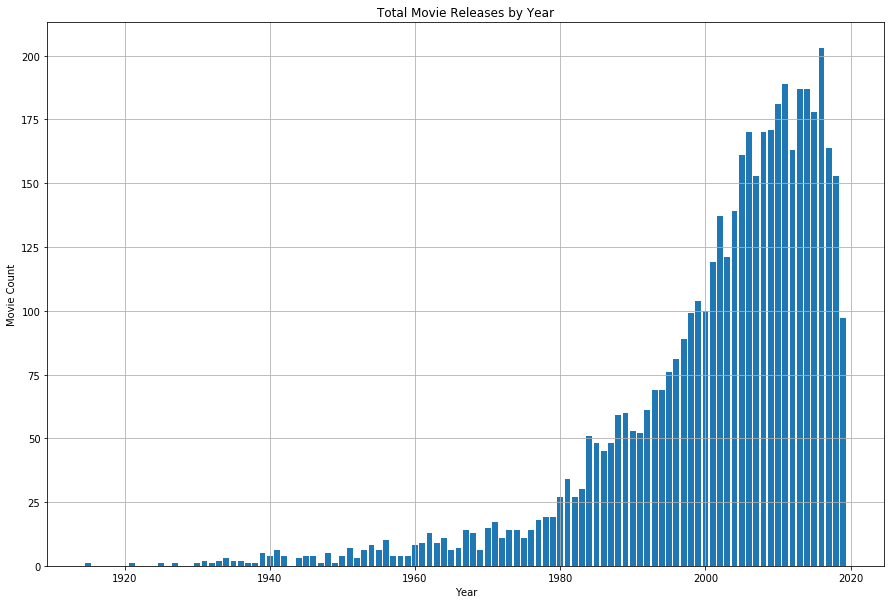

In [6]:
graphs.sum_of_releases()

<h2><center> Compare movie profit based on release month</center></h2>

* Limited scope to movies released after 1980 due to erroneous data related to profits and budgets
* Movies released prior to 1980 were inconsistently adjusted for inflation (and accurate records were not available)
* Movies released in the Summer tend to rake in the most profit 

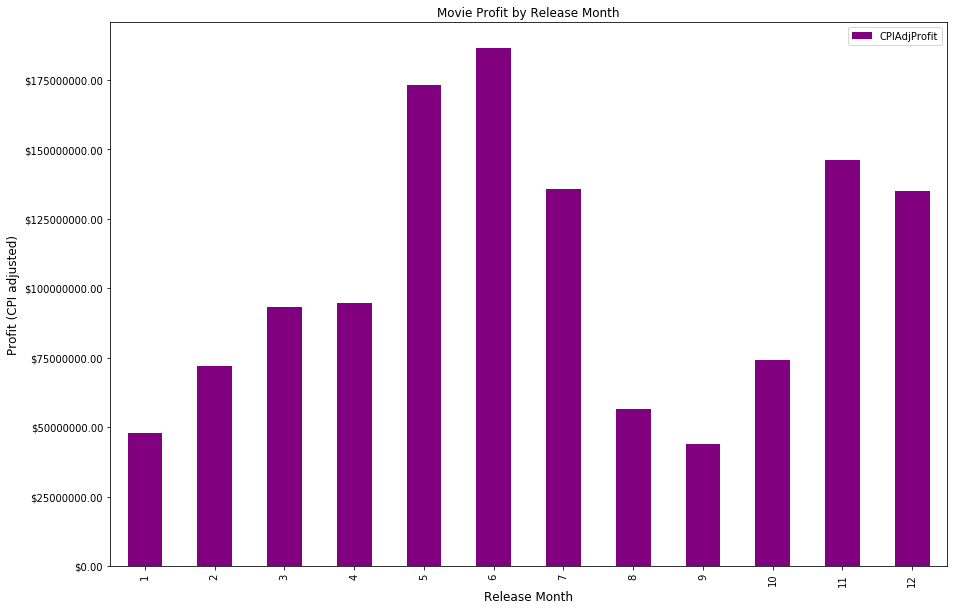

In [2]:
graphs.tmbd_1980_profit()

<h2><center>Compare TMBD user vote average by "Best Picture" result</center></h2>

* TMBD user vote average appears to correlate to the Oscar "Best Picture" results
* Movies with the highest scores are more likely to be nominated and win an Oscar for "Best Picture"
* Movies with the lowest scores are least likely to be nominated for "Best Picture" 

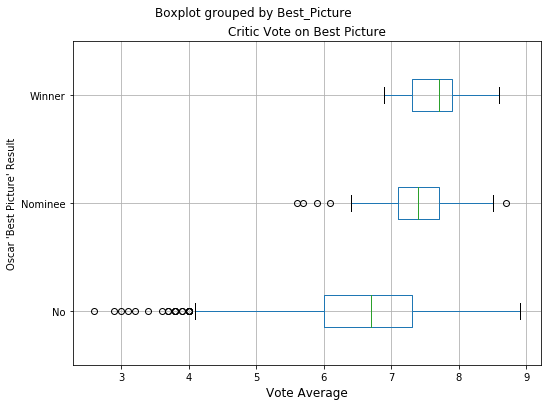

In [3]:
graphs.bestpic_vote()

<h2><center>Oscar nominations for Best Picture compared to movie release month</center></h2>

* To demonstrate that nominees for "Best Picture" correlate with release month 
* December releases are more likely to be nominated and win for "Best Picture"
* Fall releases are more likely to be nominated compared to Summer releases

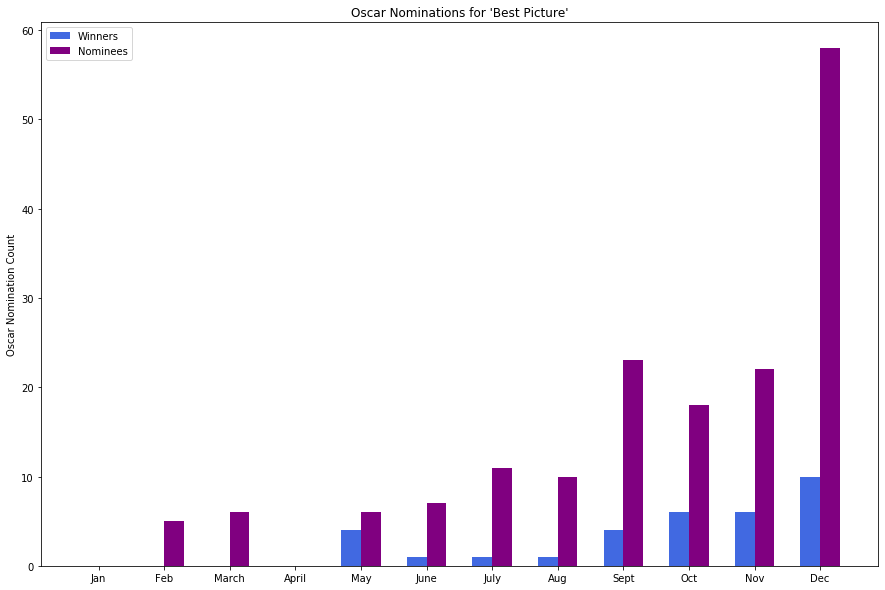

In [4]:
graphs.bp_by_month()

### Project Pain Points

* We had a lot of bad data in terms of budget/revenue that needed some serious TLC 
* The API JSON response came over as a list of multiple nested dictionaries which posed a challenge for data munging 
* Git Forking proved to be more of a challenge than expected 
* Seaborn wouldve helped visualize correlations but we faced issues in running the package consistently